# 代码清单10-18 	加载工业数据集

In [1]:
import numpy as np #导入numpy工具包
sensor_num = 23 #传感器数量
horizon = 5 #预测的时间步数
PV_index = [idx for idx in range(9)] #PV变量的索引值范围
OP_index = [idx for idx in range(9,18)] #OP变量的索引值范围
DV_index = [idx for idx in range(18,sensor_num)] #DV变量的索引值范围
data_path = '1731591426495-jl_data_train.csv' #数据文件路径
data = np.loadtxt(data_path, delimiter=',', skiprows=1, usecols=range(1,sensor_num+1)) #读取数据（忽略第1行的标题及第1列的时间戳）
print('数据形状：{0}，元素类型：{1}'.format(data.shape, data.dtype))

数据形状：(14516, 23)，元素类型：float64


# 代码清单10-19 绘制传感器数据

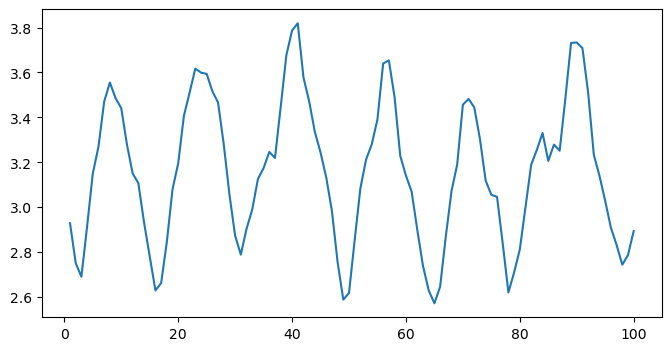

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(range(1,101), data[:100,0]) # 绘制第1个传感器的前100条数据
plt.show()

# 代码清单10-20 	定义生成模型输入/输出数据的generateData函数

In [3]:
def generateData(data, X_len, Y_len, sensor_num):#定义generateData函数
    point_num = data.shape[0] #时间点总数
    sample_num = point_num-X_len-Y_len+1 #生成的总样本数
    X = np.zeros((sample_num, X_len, sensor_num)) #用于保存输入数据
    Y = np.zeros((sample_num, Y_len, sensor_num)) #用于保存对应的输出数据
    for i in range(sample_num): #通过遍历逐一生成输入数据和对应的输出数据
        X[i] = data[i:i+X_len] #前X_len个时间点数据组成输入数据
        Y[i] = data[i+X_len:i+X_len+Y_len]#后Y_len个时间点数据组成输出数据
    return X, Y #返回所生成的模型的输入数据X和输出数据Y

# 代码清单10-21 	生成用于工业时序预测模型的数据集

In [4]:
X_t1, Y_t1 = generateData(data, 30, 1, sensor_num) #生成任务1所用的数据集
X_t2, Y_t2 = generateData(data, 30, horizon, sensor_num) #生成任务2所用的数据集
print('任务1数据集输入数据形状：{0}，输出数据形状：{1}'.format(X_t1.shape, Y_t1.shape))
print('任务2数据集输入数据形状：{0}，输出数据形状：{1}'.format(X_t2.shape, Y_t2.shape))

任务1数据集输入数据形状：(14486, 30, 23)，输出数据形状：(14486, 1, 23)
任务2数据集输入数据形状：(14482, 30, 23)，输出数据形状：(14482, 5, 23)


# 代码清单10-22 	定义用于划分训练集、验证集、测试集的splitData函数

In [5]:
def splitData(X, Y): #定义splitData函数
    N = X.shape[0] #样本总数
    train_X,train_Y=X[:int(N*0.6)],Y[:int(N*0.6)] #前60%的数据作为训练集
    val_X,val_Y=X[int(N*0.6):int(N*0.8)],Y[int(N*0.6):int(N*0.8)] #中间20%的数据作为验证集
    test_X,test_Y=X[int(N*0.8):],Y[int(N*0.8):] #最后20%的数据作为测试集
    return train_X,train_Y, val_X,val_Y, test_X,test_Y#返回划分好的数据集

# 代码清单10-23 	生成训练集、验证集和测试集

In [6]:
train_X_t1, train_Y_t1, val_X_t1, val_Y_t1, test_X_t1, test_Y_t1=splitData(X_t1, Y_t1) #划分任务1的数据集
train_X_t2, train_Y_t2, val_X_t2, val_Y_t2, test_X_t2, test_Y_t2=splitData(X_t2, Y_t2) #划分任务2的数据集
s = '训练集样本数：{0}，验证集样本数：{1}，测试集样本数：{2}'
print('任务1'+s.format(train_X_t1.shape[0], val_X_t1.shape[0], test_X_t1.shape[0])) #输出任务1训练集、验证集和测试集的样本数
print('任务2'+s.format(train_X_t2.shape[0], val_X_t2.shape[0], test_X_t2.shape[0])) #输出任务2训练集、验证集和测试集的样本数

任务1训练集样本数：8691，验证集样本数：2897，测试集样本数：2898
任务2训练集样本数：8689，验证集样本数：2896，测试集样本数：2897


# 代码清单10-24 定义多元时间序列数据集类MultiTimeSeriesDataset

In [7]:
class MultiTimeSeriesDataset(): #定义MultiTimeSeriesDataset类
    def __init__(self, X, Y): #构造方法
        self.X, self.Y = X, Y #设置输入数据和输出数据
    def __len__(self):
        return len(self.X) #获取数据的长度
    def __getitem__(self, index):
        return self.X[index], self.Y[index] #根据索引值为index的数据

# 代码清单10-25 定义用于生成训练集、验证集和测试集的generateMindsporeDataset函数

In [8]:
from mindspore import Tensor #导入Tensor类
from mindspore.dataset import GeneratorDataset #导入GeneratorDataset类
def generateMindsporeDataset(X, Y, batch_size): #定义generateMindsporeDataset函数
    dataset = MultiTimeSeriesDataset(X.astype(np.float32), Y.astype(np.float32)) #根据X和Y创建MultiTimeSeriesDataset类对象
    dataset = GeneratorDataset(dataset, column_names=['data','label']) #创建GeneratorDataset类对象，并指定数据集两列的列名称分别是data和label
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False) #将数据集分成多个批次，以支持批量训练
    return dataset #返回可用于模型训练和测试的数据集

# 代码清单10-26 生成任务1的训练集、验证集和测试集

In [9]:
train_dataset_t1 = generateMindsporeDataset(train_X_t1, train_Y_t1, batch_size=32)
val_dataset_t1 = generateMindsporeDataset(val_X_t1, val_Y_t1, batch_size=32)
test_dataset_t1 = generateMindsporeDataset(test_X_t1, test_Y_t1, batch_size=32)
for data, label in train_dataset_t1.create_tuple_iterator():
    print('数据形状：', data.shape, '，数据类型：', data.dtype)
    print('标签形状：', label.shape, '，数据类型：', label.dtype)
    break

数据形状： (32, 30, 23) ，数据类型： Float32
标签形状： (32, 1, 23) ，数据类型： Float32


# 代码清单10-27 生成任务2的训练集、验证集和测试集

In [10]:
train_dataset_t2 = generateMindsporeDataset(train_X_t2, train_Y_t2, batch_size=32)
val_dataset_t2 = generateMindsporeDataset(val_X_t2, val_Y_t2, batch_size=32)
test_dataset_t2 = generateMindsporeDataset(test_X_t2, test_Y_t2, batch_size=32)

# 代码清单10-28 定义TCN_MLP类

In [11]:
import mindspore
from mindspore import nn
class TCN_MLP(nn.Cell): #定义TCN_MLP类
    def __init__(self): #构造方法
        super().__init__() #调用父类的构造方法
        #对不同传感器的数据做融合（提取传感器数据间的关联特征）
        self.spatial_mlp = nn.SequentialCell(
            nn.Dense(sensor_num, 128),
            nn.ReLU(),
            nn.Dense(128, 64),
            nn.ReLU(),
            nn.Dense(64, 32),
            nn.ReLU(),
            nn.Dense(32, sensor_num)
        )        
        #对时间序列做卷积（提取时间点数据间的关联特征）
        self.tcn = nn.SequentialCell(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
        )
        #通过一个卷积层得到最后的预测结果
        self.final_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(26, 1), pad_mode='valid') #使用26*1卷积核，不补边
    def construct(self, x, step=None): #construct方法
        #输入数据x的形状：[batch_size, 30, 23]
        h = self.spatial_mlp(x) #经过spatial_mlp空间处理后，得到的数据h的形状：[batch_size, 30, 23]
        x = x + h #残差连接，将x和h对应元素相加，得到的数据x的形状：[batch_size, 30, 23]
        x = x.unsqueeze(1) #根据卷积操作需要，将3维数据升为4维数据：[batch_size, 1, 30, 23]
        x = self.tcn(x) #经过tcn时间卷积后，得到的数据x的形状：[batch_size, 1, 26, 23]
        y = self.final_conv(x) #通过26*1的卷积操作后，得到的数据y的形状：[batch_size, 1, 1, 23]
        y = y.squeeze(1) #将前面增加的维度去掉，得到的数据y的形状：[batch_size, 1, 23]
        return y #返回计算结果

# 代码清单10-29 定义MODEL_RUN类

In [16]:
import mindspore #导入mindspore
mindspore.set_context(mode=mindspore.GRAPH_MODE) #设置为静态图模式
class MODEL_RUN: #定义MODEL_RUN类
    def __init__(self, model, loss_fn, optimizer=None, grad_fn=None): #构造方法
        self.model = model #设置模型
        self.loss_fn = loss_fn #设置损失函数
        self.optimizer = optimizer #设置优化器
        self.grad_fn = grad_fn #设置梯度计算函数
    def _train_one_step(self, data, label): #定义用于单步训练的_train_one_step方法
        (loss, _), grads = self.grad_fn(data, label) #根据数据和标签计算损失和梯度
        self.optimizer(grads) #根据梯度进行模型优化
        return loss #返回损失值
    def _train_one_epoch(self, train_dataset): #定义用于一轮训练的_train_one_epoch方法
        self.model.set_train(True) #设置为训练模式
        for data, label in train_dataset.create_tuple_iterator(): #取出每一批数据
            self._train_one_step(data, label) #调用_train_one_step方法进行模型参数优化
    def evaluate(self, dataset, step=None): #定义用于评估模型的evaluate方法
        self.model.set_train(False) #设置为测试模式
        ls_pred,ls_label=[],[] #分别用于保存预测结果和标签
        for data, label in dataset.create_tuple_iterator(): #遍历每批数据
            pred = self.model(data) #使用模型对一批数据进行预测
            ls_pred += list(pred[:,:,PV_index].asnumpy()) #保存预测结果
            ls_label += list(label[:,:,PV_index].asnumpy()) #保存标签
        return loss_fn(Tensor(ls_pred), Tensor(ls_label)), np.array(ls_pred), np.array(ls_label)
    def train(self, train_dataset, val_dataset, max_epoch_num, ckpt_file_path): #定义用于训练模型的train方法
        min_loss = Tensor(np.float32('inf'))
        print('开始训练......')
        for epoch in range(1,max_epoch_num+1): #迭代训练
            print('第{0}/{1}轮'.format(epoch,max_epoch_num)) #输出当前迭代轮数/总轮数
            self._train_one_epoch(train_dataset) #调用_train_one_epoch完成一轮训练
            train_loss,_,_ = self.evaluate(train_dataset) #在训练集上计算模型损失值
            eval_loss,_,_ = self.evaluate(val_dataset) #在验证集上计算模型损失值
            print('训练集损失：{0}，验证集损失：{1}'.format(train_loss,eval_loss))
            if eval_loss < min_loss: #如果验证集损失值低于原来保存的最小损失值
                mindspore.save_checkpoint(self.model, ckpt_file_path) #更新最优模型文件
                min_loss = eval_loss #保存新的最小损失值
        print('训练完成！')
    def test(self, test_dataset, ckpt_file_path): #定义用于测试模型的test方法
        mindspore.load_checkpoint(ckpt_file_path, net=self.model) #从文件中加载模型
        loss,preds,labels = self.evaluate(test_dataset) #在测试集上计算模型损失值
        return loss,preds,labels #返回损失值

# 代码清单10-30 进行单步预测模型的训练

In [17]:
tcn_mlp = TCN_MLP() #创建TCN_MLP类对象tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
optimizer = nn.Adam(tcn_mlp.trainable_params(), 1e-3) #使用Adam优化器
def forward_fn(data, label): #定义前向计算的forward_fn函数
    pred = tcn_mlp(data) #使用tcn_mlp模型进行预测
    loss = loss_fn(pred[:,:,PV_index], label[:,:,PV_index]) #根据损失函数计算PV变量的损失值
    return loss, pred #返回损失值和预测结果
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True) #获取用于计算梯度的函数
model_run = MODEL_RUN(tcn_mlp, loss_fn, optimizer, grad_fn) #创建MODEL_RUN类对象model_run
model_run.train(train_dataset=train_dataset_t1, val_dataset=val_dataset_t1, max_epoch_num=50, ckpt_file_path='tcn_mlp.ckpt') #调用model_run.train方法完成训练

[WARNING] ME(17796:24592,MainProcess):2024-11-24-01:17:05.670.000 [mindspore\common\api.py:114] The function "after_grad" at the file "d:\withoutchinese_anaconda\envs\TSF_M\Lib\site-packages\mindspore\ops\composite\base.py", line 604 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


开始训练......
第1/50轮
训练集损失：0.24077685，验证集损失：0.29552338
第2/50轮
训练集损失：0.21582884，验证集损失：0.27735114
第3/50轮
训练集损失：0.19469549，验证集损失：0.25733316
第4/50轮
训练集损失：0.17471717，验证集损失：0.24834605
第5/50轮
训练集损失：0.15743999，验证集损失：0.2491745
第6/50轮
训练集损失：0.14494216，验证集损失：0.23413701
第7/50轮
训练集损失：0.13387226，验证集损失：0.22902526
第8/50轮
训练集损失：0.12544648，验证集损失：0.20566393
第9/50轮
训练集损失：0.11814008，验证集损失：0.18716618
第10/50轮
训练集损失：0.11275979，验证集损失：0.17810959
第11/50轮
训练集损失：0.10942147，验证集损失：0.17059553
第12/50轮
训练集损失：0.10720422，验证集损失：0.16332707
第13/50轮
训练集损失：0.10512744，验证集损失：0.1622194
第14/50轮
训练集损失：0.10445683，验证集损失：0.15738568
第15/50轮
训练集损失：0.10296545，验证集损失：0.15356457
第16/50轮
训练集损失：0.10185383，验证集损失：0.15409435
第17/50轮
训练集损失：0.1019658，验证集损失：0.15757321
第18/50轮
训练集损失：0.101208694，验证集损失：0.1563548
第19/50轮
训练集损失：0.10141893，验证集损失：0.1549103
第20/50轮
训练集损失：0.10059389，验证集损失：0.1624008
第21/50轮
训练集损失：0.09909231，验证集损失：0.15538989
第22/50轮
训练集损失：0.09893702，验证集损失：0.15775338
第23/50轮
训练集损失：0.09790018，验证集损失：0.15737835
第24/50轮
训练集损失：0.09811198，验证集损失：0.1611

# 代码清单10-31 进行单步预测模型的测试

训练集损失：0.10296545，验证集损失：0.15356457，测试集损失：0.14400505


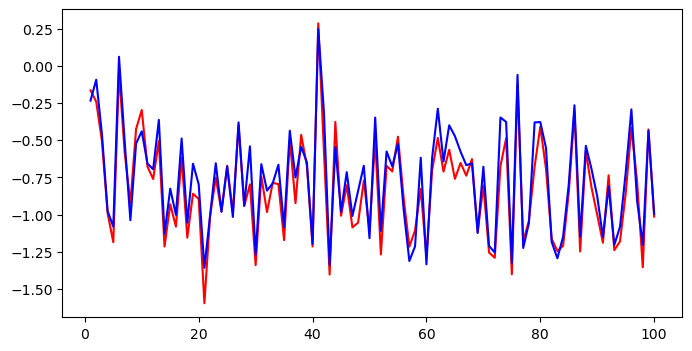

In [19]:
tcn_mlp = TCN_MLP() #创建TCN_MLP类对象tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
model_run = MODEL_RUN(tcn_mlp, loss_fn) #创建MODEL_RUN类对象model_run
train_loss,_,_ = model_run.test(train_dataset_t1, 'tcn_mlp.ckpt') #计算训练集损失
val_loss,_,_ = model_run.test(val_dataset_t1, 'tcn_mlp.ckpt') #计算验证集损失
test_loss,preds,labels = model_run.test(test_dataset_t1, 'tcn_mlp.ckpt') #计算测试集损失
print('训练集损失：{0}，验证集损失：{1}，测试集损失：{2}'.format(train_loss,val_loss,test_loss))
plt.figure(figsize=(8, 4))
plt.plot(range(1,101), preds[:100,0,0], color='Red') # 绘制第1个传感器的前100条数据的预测结果
plt.plot(range(1,101), labels[:100,0,0], color='Blue') # 绘制第1个传感器的前100条数据的标签
plt.show()

# 代码清单10-32 定义MULTI_STEP_MODEL_RUN类

In [15]:
class MULTI_STEP_MODEL_RUN(MODEL_RUN): #定义MULTI_STEP_MODEL_RUN类
    def __init__(self, model, loss_fn, optimizer=None, grad_fn=None): #构造方法
        super().__init__(model, loss_fn, optimizer, grad_fn)
    def evaluate(self, dataset): #重定义evaluate方法
        self.model.set_train(False) #设置为测试模式
        ls_pred,ls_label=[],[] #分别用于保存预测结果和标签
        for data, label in dataset.create_tuple_iterator(): #遍历每批数据
            muti_step_pred = mindspore.numpy.zeros_like(label[:,:,PV_index])
            x = data
            for step in range(horizon):
                pred = self.model(x, step) #使用sa_tcn_mlp模型进行预测
                muti_step_pred[:,step:step+1,:] = pred[:,:,PV_index] #将当前时间步的预测结果保存到multi_step_pred中
                concat_op = mindspore.ops.Concat(axis=1)
                x = concat_op((x[:,1:,:], pred)) #将预测结果加到输入中
                x[:,-1:,OP_index] = label[:,step:step+1,OP_index] #OP控制变量无法预测、始终使用真实值
            ls_pred += list(muti_step_pred.asnumpy()) #保存预测结果
            ls_label += list(label[:,:,PV_index].asnumpy()) #保存标签
        return loss_fn(Tensor(ls_pred), Tensor(ls_label)),np.array(ls_pred),np.array(ls_label)

# 代码清单10-33 直接用单步预测方式训练的TCN_MLP模型进行迭代多步预测

训练集损失：0.18405068，验证集损失：0.3527572，测试集损失：0.4035026


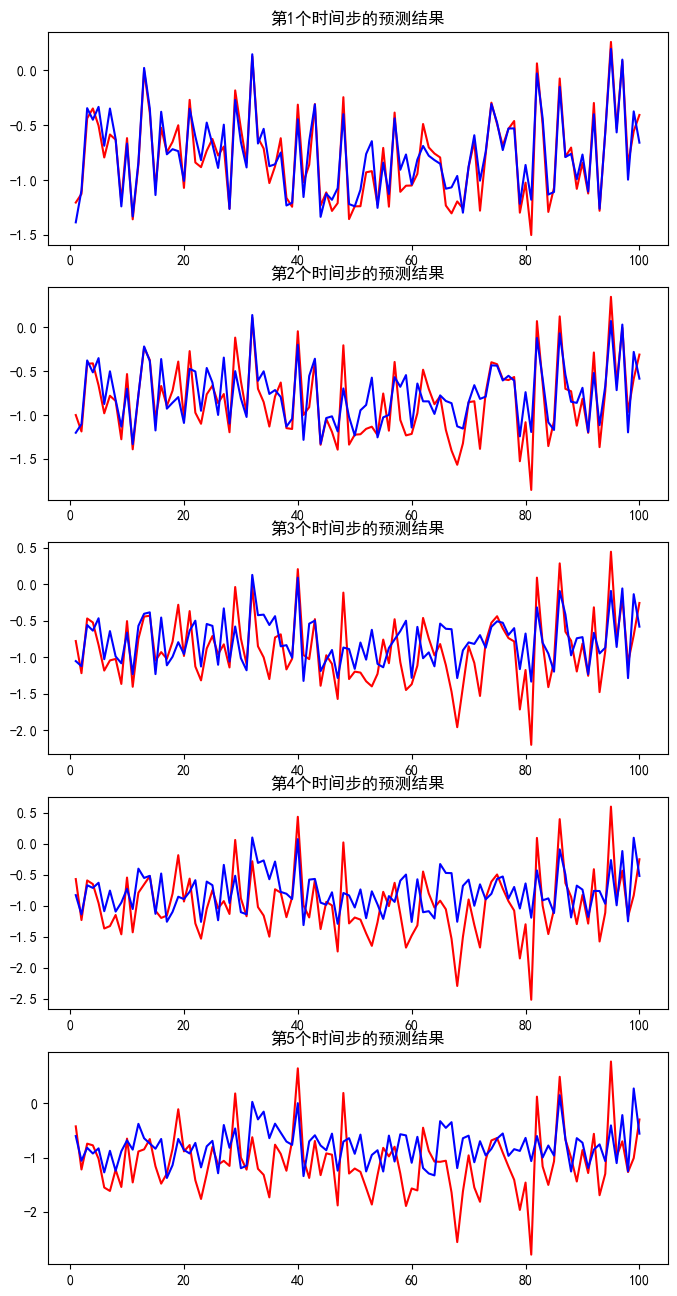

In [16]:
tcn_mlp = TCN_MLP() #创建TCN_MLP类对象tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(tcn_mlp, loss_fn) #创建MULTI_STEP_MODEL_RUN类对象multi_step_model_run
train_loss,_,_ = multi_step_model_run.test(train_dataset_t2, 'tcn_mlp.ckpt') #计算训练集损失
val_loss,_,_ = multi_step_model_run.test(val_dataset_t2, 'tcn_mlp.ckpt') #计算验证集损失
test_loss,preds,labels = multi_step_model_run.test(test_dataset_t2, 'tcn_mlp.ckpt') #计算测试集损失
print('训练集损失：{0}，验证集损失：{1}，测试集损失：{2}'.format(train_loss,val_loss,test_loss))
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
_,axes = plt.subplots(5,1,figsize=(8, 16))
interval = int(horizon/5)
for step in range(5):
    axes[step].set_title('第%d个时间步的预测结果'%(step*interval+1))
    axes[step].plot(range(1,101), preds[:100,step*interval,0], color='Red') # 绘制第1个传感器的前100条数据的预测结果
    axes[step].plot(range(1,101), labels[:100,step*interval,0], color='Blue') # 绘制第1个传感器的前100条数据的标签

# 代码清单10-34 用迭代多步预测方式重新训练TCN_MLP模型

In [17]:
multi_step_tcn_mlp = TCN_MLP() #创建TCN_MLP类对象multi_step_tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
multi_step_optimizer = nn.Adam(multi_step_tcn_mlp.trainable_params(), 1e-3) #使用Adam优化器
def multi_step_forward_fn(data, label): #定义多步预测前向计算的multi_step_forward_fn方法
    muti_step_pred = mindspore.numpy.zeros_like(label[:,:,PV_index+DV_index])
    x = data
    for step in range(horizon):
        pred = multi_step_tcn_mlp(x, step) #使用multi_step__tcn_mlp模型进行预测
        muti_step_pred[:,step:step+1,:] = pred[:,:,PV_index+DV_index] #将当前时间步的预测结果保存到multi_step_pred中
        concat_op = mindspore.ops.Concat(axis=1)
        x = concat_op((x[:,1:,:], pred)) #将预测结果加到输入中
        x[:,-1:,OP_index] = label[:,step:step+1,OP_index] #OP控制变量无法预测、始终使用真实值
    loss = loss_fn(muti_step_pred, label[:,:,PV_index+DV_index]) #根据损失函数计算PV和DV变量的损失值
    return loss, muti_step_pred #返回损失值和预测结果
multi_step_grad_fn = mindspore.value_and_grad(multi_step_forward_fn, None, multi_step_optimizer.parameters, has_aux=True) #获取用于计算梯度的函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(multi_step_tcn_mlp, loss_fn, multi_step_optimizer, multi_step_grad_fn) #创建MULTI_STEP_MODEL_RUN类对象multi_step_model_run
multi_step_model_run.train(train_dataset_t2, val_dataset_t2, 10, 'multi_step_tcn_mlp.ckpt') #调用multi_step_model_run.train方法完成训练

[WARNING] ME(13964:18852,MainProcess):2024-01-13-17:00:28.970.587 [mindspore\common\api.py:466] The function "after_grad" at the file "C:\ProgramData\Anaconda3\lib\site-packages\mindspore\ops\composite\base.py", line 587 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


开始训练......
第1/10轮
训练集损失：0.25360182，验证集损失：0.3138596
第2/10轮
训练集损失：0.23373596，验证集损失：0.29260883
第3/10轮
训练集损失：0.2237426，验证集损失：0.28667635
第4/10轮
训练集损失：0.21677928，验证集损失：0.2971085
第5/10轮
训练集损失：0.20996968，验证集损失：0.3091132
第6/10轮
训练集损失：0.20339996，验证集损失：0.32242146
第7/10轮
训练集损失：0.19638006，验证集损失：0.33756986
第8/10轮
训练集损失：0.19272424，验证集损失：0.35590976
第9/10轮
训练集损失：0.18599989，验证集损失：0.36715803
第10/10轮
训练集损失：0.18328623，验证集损失：0.3755899
训练完成！


# 代码清单10-35 对用迭代多步预测方式重新训练的TCN_MLP模型进行测试

训练集损失：0.2237426，验证集损失：0.28667635，测试集损失：0.25961894


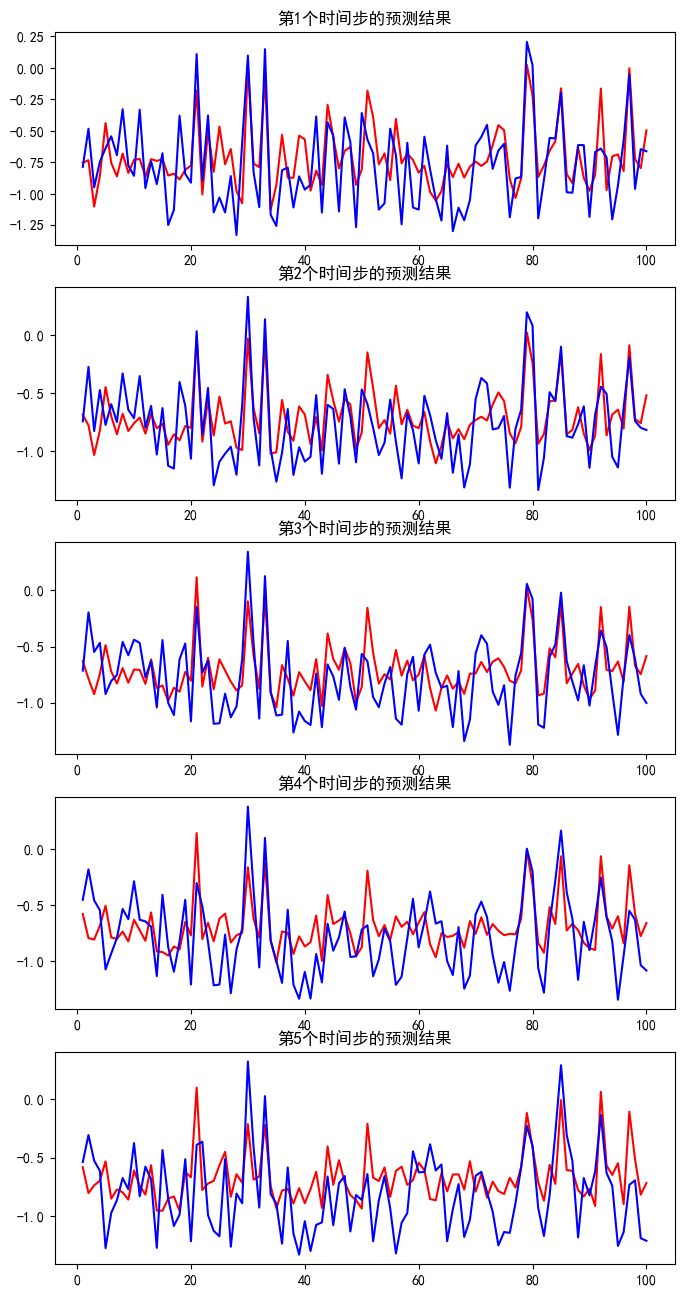

In [18]:
multi_step_tcn_mlp = TCN_MLP() #创建TCN_MLP类对象multi_step_tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(multi_step_tcn_mlp, loss_fn) #创建MULTI_STEP_MODEL_RUN类对象multi_step_model_run
train_loss,_,_ = multi_step_model_run.test(train_dataset_t2, 'multi_step_tcn_mlp.ckpt') #计算训练集损失
val_loss,_,_ = multi_step_model_run.test(val_dataset_t2, 'multi_step_tcn_mlp.ckpt') #计算验证集损失
test_loss,preds,labels = multi_step_model_run.test(test_dataset_t2, 'multi_step_tcn_mlp.ckpt') #计算测试集损失
print('训练集损失：{0}，验证集损失：{1}，测试集损失：{2}'.format(train_loss,val_loss,test_loss))
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
_,axes = plt.subplots(5,1,figsize=(8, 16))
interval = int(horizon/5)
for step in range(5):
    axes[step].set_title('第%d个时间步的预测结果'%(step+1))
    axes[step].plot(range(1,101), preds[:100,step*interval,0], color='Red') # 绘制第1个传感器的前100条数据的预测结果
    axes[step].plot(range(1,101), labels[:100,step*interval,0], color='Blue') # 绘制第1个传感器的前100条数据的标签

# 代码清单10-36 定义Step_Aware_TCN_MLP类

In [19]:
class Step_Aware_TCN_MLP(nn.Cell): #定义Step_Aware_TCN_MLP类
    def __init__(self): #构造方法
        super().__init__() #调用父类的构造方法
        #比TCN_MLP新增一个对预测时间步数据的嵌入编码操作
        self.step_embedding = nn.Embedding(horizon, 30)
        #对不同传感器的数据做融合（提取传感器数据间的关联特征）
        self.spatial_mlp = nn.SequentialCell(
            nn.Dense(sensor_num+1, 128), #输入数据新增了时间步数据的嵌入编码
            nn.ReLU(),
            nn.Dense(128, 64),
            nn.ReLU(),
            nn.Dense(64, 32),
            nn.ReLU(),
            nn.Dense(32, sensor_num)
        )
        #对时间序列做卷积（提取时间点数据间的关联特征）
        self.tcn = nn.SequentialCell(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
        )
        #通过一个卷积层得到最后的预测结果
        self.final_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(26, 1), pad_mode='valid') #使用26*1卷积核，不补边
    def construct(self, x, iter_step): #construct方法
        #计算时间步数据的嵌入编码
        iter_step_tensor = mindspore.numpy.full((x.shape[0], 1), iter_step, dtype=mindspore.int32)
        step_embedding = self.step_embedding(iter_step_tensor) #step_embedding的形状：[batch_size,1,30]
        #将输入数据x与时间步数据的嵌入编码拼接
        concat_op = mindspore.ops.Concat(axis=2)
        step_embedding_ = step_embedding.swapaxes(1,2) #将两个维度交换，以支持与输入数据x的拼接
        x_ = concat_op((x, step_embedding_)) #x_的形状：[batch_size,30,23+1]
        h = self.spatial_mlp(x_) #经过spatial_mlp空间处理后，得到的数据h的形状：[batch_size, 30, 23]
        #输入数据x的形状：[batch_size, 30, 23]
        x = x + h #残差连接，将x和h对应元素相加，得到的数据x的形状：[batch_size, 30, 23]
        x = x.unsqueeze(1) #根据卷积操作需要，将3维数据升为4维数据：[batch_size, 1, 30, 23]
        x = self.tcn(x) #经过tcn时间卷积后，得到的数据x的形状：[batch_size, 1, 26, 23]
        y = self.final_conv(x) #通过26*1的卷积操作后，得到的数据y的形状：[batch_size, 1, 1, 23]
        y = y.squeeze(1) #将前面增加的维度去掉，得到的数据y的形状：[batch_size, 1, 23]
        return y #返回计算结果

# 代码清单10-37 进行Step_Aware_TCN_MLP多步预测模型的训练

In [20]:
sa_tcn_mlp = Step_Aware_TCN_MLP() #创建Step_Aware_TCN_MLP类对象sa_tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
multi_step_optimizer = nn.Adam(sa_tcn_mlp.trainable_params(), 1e-3) #使用Adam优化器
def multi_step_forward_fn(data, label): #定义多步预测前向计算的multi_step_forward_fn方法
    muti_step_pred = mindspore.numpy.zeros_like(label[:,:,PV_index+DV_index])
    x = data
    for step in range(horizon):
        pred = sa_tcn_mlp(x, step) #使用sa_tcn_mlp模型进行预测
        muti_step_pred[:,step:step+1,:] = pred[:,:,PV_index+DV_index] #将当前时间步的预测结果保存到multi_step_pred中
        concat_op = mindspore.ops.Concat(axis=1)
        x = concat_op((x[:,1:,:], pred)) #将预测结果加到输入中
        x[:,-1:,OP_index] = label[:,step:step+1,OP_index] #OP控制变量无法预测、始终使用真实值
    loss = loss_fn(muti_step_pred, label[:,:,PV_index+DV_index]) #根据损失函数计算PV和DV变量的损失值
    return loss, muti_step_pred #返回损失值和预测结果
multi_step_grad_fn = mindspore.value_and_grad(multi_step_forward_fn, None, multi_step_optimizer.parameters, has_aux=True) #获取用于计算梯度的函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(sa_tcn_mlp, loss_fn, multi_step_optimizer, multi_step_grad_fn) #创建MODEL_RUN类对象model_run
multi_step_model_run.train(train_dataset_t2, val_dataset_t2, 10, 'sa_tcn_mlp.ckpt') #调用model_run.train方法完成训练

[WARNING] ME(13964:18852,MainProcess):2024-01-13-17:03:18.450.724 [mindspore\common\api.py:466] The function "after_grad" at the file "C:\ProgramData\Anaconda3\lib\site-packages\mindspore\ops\composite\base.py", line 587 has been compiled again. Try to decorate the function with @jit(hash_args=...) or @jit(compile_once=True) to reduce the compile time. For more details, get instructions about `jit` at https://www.mindspore.cn/search?inputValue=jit. 


开始训练......
第1/10轮
训练集损失：0.2596667，验证集损失：0.31359434
第2/10轮
训练集损失：0.23568296，验证集损失：0.28494492
第3/10轮
训练集损失：0.22272797，验证集损失：0.2757552
第4/10轮
训练集损失：0.21162741，验证集损失：0.2791961
第5/10轮
训练集损失：0.20219244，验证集损失：0.29553118
第6/10轮
训练集损失：0.19290401，验证集损失：0.3157113
第7/10轮
训练集损失：0.18197292，验证集损失：0.32828653
第8/10轮
训练集损失：0.17340423，验证集损失：0.3443465
第9/10轮
训练集损失：0.16858542，验证集损失：0.3611464
第10/10轮
训练集损失：0.16494644，验证集损失：0.36675557
训练完成！


# 代码清单10-38 进行Step_Aware_TCN_MLP多步预测模型的测试

训练集损失：0.22272797，验证集损失：0.2757552，测试集损失：0.24642661


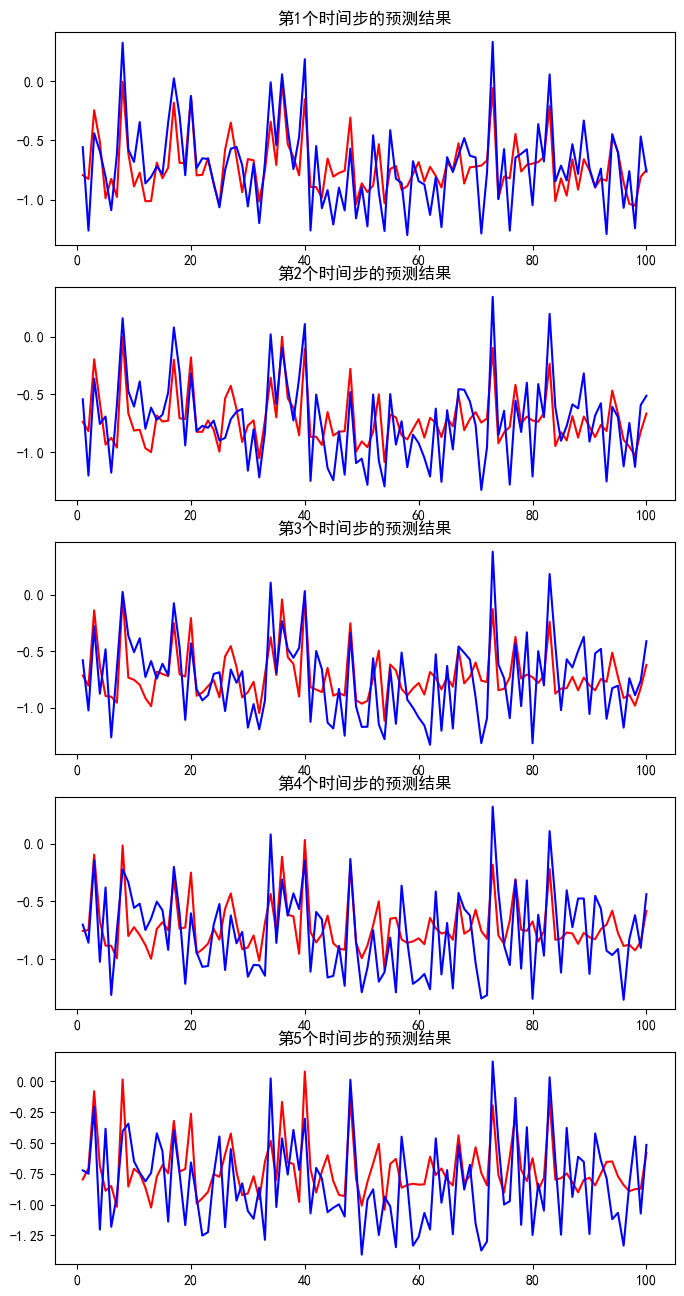

In [21]:
sa_tcn_mlp = Step_Aware_TCN_MLP() #创建Step_Aware_TCN_MLP类对象sa_tcn_mlp
loss_fn = nn.MAELoss() #定义损失函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(sa_tcn_mlp, loss_fn) #创建MULTI_STEP_MODEL_RUN类对象multi_step_model_run
train_loss,_,_ = multi_step_model_run.test(train_dataset_t2, 'sa_tcn_mlp.ckpt') #计算训练集损失
val_loss,_,_ = multi_step_model_run.test(val_dataset_t2, 'sa_tcn_mlp.ckpt') #计算验证集损失
test_loss,preds,labels = multi_step_model_run.test(test_dataset_t2, 'sa_tcn_mlp.ckpt') #计算测试集损失
print('训练集损失：{0}，验证集损失：{1}，测试集损失：{2}'.format(train_loss,val_loss,test_loss))
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
_,axes = plt.subplots(5,1,figsize=(8, 16))
interval = int(horizon/5)
for step in range(5):
    axes[step].set_title('第%d个时间步的预测结果'%(step*interval+1))
    axes[step].plot(range(1,101), preds[:100,step*interval,0], color='Red') # 绘制第1个传感器的前100条数据的预测结果
    axes[step].plot(range(1,101), labels[:100,step*interval,0], color='Blue') # 绘制第1个传感器的前100条数据的标签

# 基于偏差块的模型优化

## 1、定义TCN_MLP_with_Bias_Block类

In [20]:
class TCN_MLP_with_Bias_Block(nn.Cell): #定义TCN_MLP_with_Bias_Block类
    def __init__(self): #构造方法
        super().__init__() #调用父类的构造方法
        #比MULTI_STEP_TCN_MLP类增加一个偏差块
        self.bias_block = nn.SequentialCell(
            nn.Dense(sensor_num, 64),
            nn.ReLU(),
            nn.Dense(64, 32),
            nn.ReLU(),
            nn.Dense(32, sensor_num),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(32,1), pad_mode='valid')
        )
        #对预测时间步数据的嵌入编码操作
        self.step_embedding = nn.Embedding(horizon, sensor_num)
        #对不同传感器的数据做融合（提取传感器数据间的关联特征）
        self.spatial_mlp = nn.SequentialCell(
            nn.Dense(sensor_num, 128),
            nn.ReLU(),
            nn.Dense(128, 64),
            nn.ReLU(),
            nn.Dense(64, 32),
            nn.ReLU(),
            nn.Dense(32, sensor_num)
        )
        #对时间序列做卷积（提取时间点数据间的关联特征）
        self.tcn = nn.SequentialCell(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,1), pad_mode='valid'),
        )
        #通过一个卷积层得到最后的预测结果
        self.final_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(26, 1), pad_mode='valid') #使用26*1卷积核，不补边
    def construct(self, x, iter_step): #construct方法
        h = self.spatial_mlp(x) #经过spatial_mlp空间处理后，得到的数据h的形状：[batch_size, 30, 23]
        #输入数据x的形状：[batch_size, 30, 23]
        h = x + h #残差连接，将x和h对应元素相加，得到的数据h的形状：[batch_size, 30, 23]
        h = h.unsqueeze(1) #根据卷积操作需要，将3维数据升为4维数据：[batch_size, 1, 30, 23]
        h = self.tcn(h) #经过tcn时间卷积后，得到的数据x的形状：[batch_size, 1, 26, 23]
        y = self.final_conv(h) #通过26*1的卷积操作后，得到的数据y的形状：[batch_size, 1, 1, 23]
        y = y.squeeze(1) #将前面增加的维度去掉，得到的数据y的形状：[batch_size, 1, 23]
        #计算时间步数据的嵌入编码
        iter_step_tensor = mindspore.numpy.full((x.shape[0], 1), iter_step, dtype=mindspore.int32)
        step_embedding = self.step_embedding(iter_step_tensor) #step_embedding的形状：[batch_size,1,23]
        #将输入数据x与时间步数据的嵌入编码拼接
        concat_op = mindspore.ops.Concat(axis=1)
        bias_input = concat_op((x, step_embedding,y)) #bias_input的形状：[batch_size,32,23]
        bias_output = self.bias_block(bias_input.unsqueeze(1)) #[batch_size, 1, 1, 23]
        bias_output = bias_output.squeeze(1) # [batch_size, 1, 23]
        #加上偏差块的预测结果
        y = y + bias_output #y的形状：[batch_size, 1, 23]
        return y #返回计算结果

## 2、进行TCN_MLP_with_Bias_Block多步预测模型的训练

In [21]:
tcn_mlp_bias = TCN_MLP_with_Bias_Block() #创建TCN_MLP_with_Bias_Block类对象tcn_mlp_bias
loss_fn = nn.MAELoss() #定义损失函数
multi_step_optimizer = nn.Adam(tcn_mlp_bias.trainable_params(), 1e-3) #使用Adam优化器
def multi_step_forward_fn(data, label): #定义多步预测前向计算的multi_step_forward_fn方法
    muti_step_pred = mindspore.numpy.zeros_like(label[:,:,PV_index+DV_index])
    x = data
    for step in range(horizon):
        pred = tcn_mlp_bias(x, step) #使用tcn_mlp_bias模型进行预测
        muti_step_pred[:,step:step+1,:] = pred[:,:,PV_index+DV_index] #将当前时间步的预测结果保存到multi_step_pred中
        concat_op = mindspore.ops.Concat(axis=1)
        x = concat_op((x[:,1:,:], pred)) #将预测结果加到输入中
        x[:,-1:,OP_index] = label[:,step:step+1,OP_index] #OP控制变量无法预测、始终使用真实值
    loss = loss_fn(muti_step_pred, label[:,:,PV_index+DV_index]) #根据损失函数计算PV和DV变量的损失值
    return loss, muti_step_pred #返回损失值和预测结果
multi_step_grad_fn = mindspore.value_and_grad(multi_step_forward_fn, None, multi_step_optimizer.parameters, has_aux=True) #获取用于计算梯度的函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(tcn_mlp_bias, loss_fn, multi_step_optimizer, multi_step_grad_fn) #创建MODEL_RUN类对象model_run
multi_step_model_run.train(train_dataset_t2, val_dataset_t2, 10, 'tcn_mlp_bias.ckpt') #调用model_run.train方法完成训练

NameError: name 'MULTI_STEP_MODEL_RUN' is not defined

## 3、进行TCN_MLP_with_Bias_Block多步预测模型的测试

In [22]:
tcn_mlp_bias = TCN_MLP_with_Bias_Block() #创建TCN_MLP_with_Bias_Block类对象tcn_mlp_bias
loss_fn = nn.MAELoss() #定义损失函数
multi_step_model_run = MULTI_STEP_MODEL_RUN(tcn_mlp_bias, loss_fn) #创建MULTI_STEP_MODEL_RUN类对象multi_step_model_run
train_loss,_,_ = multi_step_model_run.test(train_dataset_t2, 'tcn_mlp_bias.ckpt') #计算训练集损失
val_loss,_,_ = multi_step_model_run.test(val_dataset_t2, 'tcn_mlp_bias.ckpt') #计算验证集损失
test_loss,preds,labels = multi_step_model_run.test(test_dataset_t2, 'tcn_mlp_bias.ckpt') #计算测试集损失
print('训练集损失：{0}，验证集损失：{1}，测试集损失：{2}'.format(train_loss,val_loss,test_loss))
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
_,axes = plt.subplots(5,1,figsize=(8, 16))
interval = int(horizon/5)
for step in range(5):
    axes[step].set_title('第%d个时间步的预测结果'%(step*interval+1))
    axes[step].plot(range(1,101), preds[:100,step*interval,0], color='Red') # 绘制第1个传感器的前100条数据的预测结果
    axes[step].plot(range(1,101), labels[:100,step*interval,0], color='Blue') # 绘制第1个传感器的前100条数据的标签

NameError: name 'MULTI_STEP_MODEL_RUN' is not defined